# Example Codes

Dependencies

In [ ]:
%pip install numpy scipy matplotlib

In [2]:
import numpy as np
import scipy.signal as sig
import scipy.fft as fft

a = np.array(range(5))
b = np.zeros(shape=(5))
b[0] = 1
b[1] = 1
print(a.shape)
print(b.shape)
# Convolution is commutative; order doesn't have any effect on output
c = np.convolve(b, a)



(5,)
(5,)


[(5+0j), (1+0j), (2+0j), (4+0j), ] | F0 Result = (12+0j)
[(5+0j), (6.123233995736766e-17-1j), (-2-2.4492935982947064e-16j), (-7.347880794884119e-16+4j), ] | F1 Result = (2.999999999999999+3j)
[(5+0j), (-1-1.2246467991473532e-16j), (2+4.898587196589413e-16j), (-4-1.4695761589768238e-15j), ] | F2 Result = (2-1.102182119232618e-15j)
[(5+0j), (-1.8369701987210297e-16+1j), (-2-7.347880794884119e-16j), (2.204364238465236e-15-4j), ] | F3 Result = (3.000000000000002-3.000000000000001j)
SciPy FFT: [12.-0.j  3.+3.j  2.-0.j  3.-3.j]
My FFT: [np.complex128(12+0j), np.complex128(2.999999999999999+3j), np.complex128(2-1.102182119232618e-15j), np.complex128(3.000000000000002-3.000000000000001j)]
My FFT_R2: [np.complex128(12+0j), np.complex128(3+3j), np.complex128(2+0j), np.complex128(3-3j)]


/Users/elijawhan/Documents/Develop/ConvExa/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/elijawhan/Documents/Develop/ConvExa/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


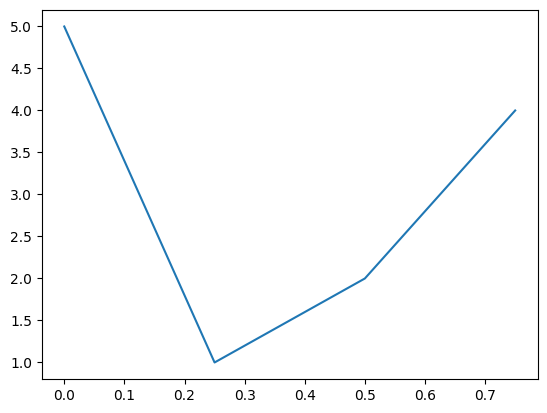

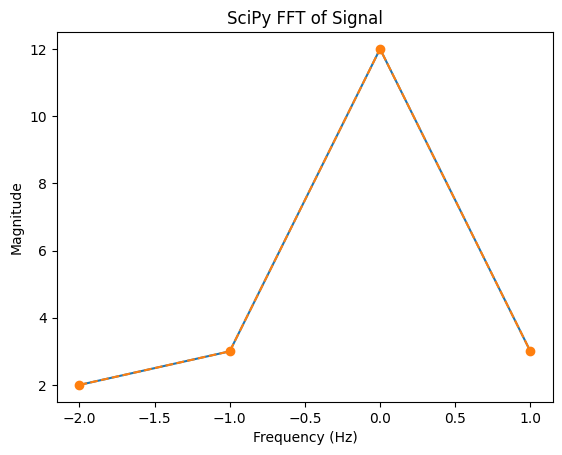

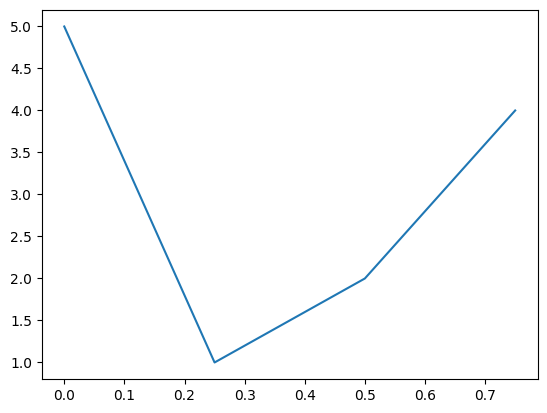

In [8]:
from matplotlib import pyplot as plt
import scipy.fft as scipyFFT


def myDFT(signal : list) -> list:
    fft = []
    N = len(signal)
    for idx, component in enumerate(signal):
        n = component
        fft.append(0)
        print("[", end="")
        for jdx, sample in enumerate(signal):
            exponential = np.exp(-(1j * 2 * np.pi * idx * jdx) / N)
            fft[idx] += signal[jdx] * exponential
            print(f"{signal[jdx] * exponential}", end=", ")
        print("]", end="")
        print(f" | F{idx} Result = {fft[idx]}")
    return fft

def myFFT_Radix2(signal):
    N = len(signal)
    if (N == 1):
        return [N]
    sigE = signal[0::2]
    sigO = signal[1::2]
    # print(f"E:{sigE}")
    # print(f"O:{sigO}")
    fftE = np.array(myFFT_Radix2(sigE))
    fftO = np.array(myFFT_Radix2(sigO))
    fftO = [np.exp(-(1j * 2 * np.pi) / N) * fftO[k] for k in range(N//2)]
    # k = range(0, int(N/2))
    # exponent = np.array(exponent)**k
    # fftO = np.multiply(fftO, exponent)
    print(f"Even: {fftE}")
    print(f"Odd: {fftO}")
    return fftE + fftO
def radix2_fft(signal):
    # Elijah's implementation
    N = len(signal)
    
    # Check if N is a power of 2
    if N <= 0 or (N & (N - 1)) != 0:
        raise ValueError("Signal length must be a power of 2")
    
    # Base case: 1-point FFT is just the signal itself
    if N == 1:
        return signal
    
    # Bit-reversal permutation (reorder input for in-place splitting)
    # NOTE: This step can increase optimization by improving locality of 
    # FFT chunks, though it is a bit unnecessary for the example implementation
    # Confusing as hell...
    def bit_reverse(n, bits):
        # local function to radix-2
        reversed = 0
        for i in range(bits):
            if (n >> i) & 1:
                reversed |= 1 << (bits - 1 - i)
        return reversed
    
    # Reorder signal
    stages = int(np.log2(N))
    output = [0] * N
    for i in range(N):
        output[bit_reverse(i, stages)] = signal[i]
    
    # Iterative FFT: Build from 2-point DFTs up to N-point
    for size in range(1, stages + 1):
        block_size = 1 << size  # 2, 4, 8, ...
        half_size = block_size // 2
        
        # Process each block
        for start in range(0, N, block_size):
            # Butterfly operations within block
            for k in range(half_size):
                even_idx = start + k
                odd_idx = start + k + half_size
                even_val = output[even_idx]
                # Twiddle factor: W_N^k = e^(-2πi k / block_size)
                twiddle = np.exp(-2j * np.pi * k / block_size)
                odd_val = twiddle * output[odd_idx]
                
                # Combine: X[k] = even + W * odd, X[k + N/2] = even - W * odd
                output[even_idx] = even_val + odd_val
                output[odd_idx] = even_val - odd_val
    
    return output

samplingFreq = 4
duration = 1
N = int(samplingFreq * duration)

time = np.linspace(0, duration, N, endpoint=False)
#signal = np.sin(10.0 * 2.0*np.pi*time) + 0.5*np.sin(25.0 * 2.0*np.pi*time)
signal = [5, 1, 2, 4]

signalFFT = scipyFFT.fft(signal)
mySignalFFT = myDFT(signal)
mySignalFFT_R2 = radix2_fft(signal)#myFFT_Radix2(signal)
print(f"SciPy FFT: {signalFFT}")
print(f"My FFT: {mySignalFFT}")
print(f"My FFT_R2: {mySignalFFT_R2}")

fft_freq = scipyFFT.fftfreq(N, 1/samplingFreq)
fft_freq_shift = scipyFFT.fftshift(fft_freq)

signalFFT_shift = scipyFFT.fftshift(signalFFT)
mySignalFFT_shift = scipyFFT.fftshift(mySignalFFT)
mySignalFFT_R2_shift = scipyFFT.fftshift(mySignalFFT_R2)

plt.figure(1)
plt.plot(time, signal)
plt.figure(2)
plt.plot(fft_freq_shift, signalFFT_shift)
#plt.plot(fft_freq_shift, mySignalFFT_shift, "--o")
plt.plot(fft_freq_shift, mySignalFFT_R2_shift, "--o")
# Display only positive frequencies (MUST MULTIPLY MAGNITUDE BY 2)
# plt.xlim(0, samplingFreq/2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("SciPy FFT of Signal")

plt.figure(3)
plt.plot(time, scipyFFT.ifft(signalFFT))



In [ ]:
from matplotlib import pyplot as plt
x = range(5)
x2 = range(9)

plt.plot(x, a, x, b, x2, c)

In [ ]:
import numpy as np
def myconv (a, b, type="full") :
    if type != "full" : # Implements "Valid" Convolution
        c = np.zeros(len(a) - len(b) + 1)
        for i in range(len(c)):
            for j in range (len(b)):
                    c[i] += a[i + j ] * b[j]
        return c
    else: # Implements "Full" convolution
        c = np.zeros(len(a) + len(b) - 1)
        for i in range(len(c)):
            for j in range (len(b)):
                a_idx = i - (len(b) - 1 - j)
                if 0 <= a_idx < len(a) : # Bounds check, zero pad emulated
                    c[i] += a[a_idx] * b[len(b) - j - 1]
        return c

def my_overlap_add(a, b, l):
    convs = np.zeros(len(a) + len(b) - 1)
    for i in range(0, len(a), l):
        conv = myconv(a[i:i + l], b)  
        for j, val in enumerate(conv):
            convs[i + j] += val

    return convs

def my_overlap_save(a, b, l):
    m = len(b) - 1
    result = []
    for i in range (0, len(a), l):
        if i +l + m < len(a) :
            result.extend( myconv(a[i:i+l + m], b, type="valid"))
        else:
            result.extend( myconv(a[i:], b, type="valid"))

    return result


In [ ]:
a = np.array(range(5))
b = np.zeros(shape=(5))
b[0] = 1
b[1] = 1
b[4] = -1
print(f"numpy: {np.convolve(a, b)}")
print(f"basic conv : {myconv(a, b)}")
print(f"overlap add : {my_overlap_add(a, b, 3)}")
print(f"overlap save : {my_overlap_save(list(a), [1, 1], 3)}")